## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)
$$

In this project, you will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, you would be able to re-utilize parts of your previous code in this project).


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


In [4]:
len(df_cap)
df_cap.tail()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2017-12-18,8.544130e+11,79769847300,1.942654e+11,86691627560,1.993489e+11,2.193544e+11,1.494954e+11,1.472788e+11,1.140145e+11,9.497734e+10,...,86568262500,2.122455e+11,197797973840,37182921720,217317756540,99938742260,214872900000,196078290000,256120499600,3.178944e+11
2017-12-19,8.707514e+11,80492369100,1.922806e+11,86763342680,1.984817e+11,2.186858e+11,1.517960e+11,1.481394e+11,1.153170e+11,9.575056e+10,...,88800607500,2.149224e+11,199285366200,37628063640,221391617770,100626816220,215972501250,197853314520,257359792340,3.172588e+11
2017-12-20,8.767894e+11,81025659000,1.975422e+11,88526339380,2.014686e+11,2.240536e+11,1.535403e+11,1.522098e+11,1.166196e+11,9.695966e+10,...,90319121250,2.125430e+11,198655115200,37807206120,221662563410,100618815360,218460123750,199132983360,259100703570,3.221319e+11
2017-12-21,8.543623e+11,79055926950,1.915055e+11,85454541740,1.962175e+11,2.192206e+11,1.508938e+11,1.481860e+11,1.134067e+11,9.474613e+10,...,86645979700,2.092118e+11,197722343720,37253493000,216717805480,98218557360,212168962500,195995730720,255795922930,3.172588e+11
2017-12-22,8.628359e+11,79253760300,1.893680e+11,85508328080,1.983372e+11,2.215511e+11,1.499164e+11,1.481394e+11,1.114095e+11,9.558758e+10,...,86171382920,2.109369e+11,197041672640,37248064440,215527579990,97786510920,214133823750,193684070880,254586137160,3.172588e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [5]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
short_rolling.head(20)

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
long_rolling.tail()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2017-12-18,8.838745e+11,8.205358e+10,2.004618e+11,9.121964e+10,2.119183e+11,2.171943e+11,1.547477e+11,1.591236e+11,1.224074e+11,9.905482e+10,...,8.595350e+10,2.143569e+11,1.993963e+11,3.782232e+10,2.170649e+11,1.032860e+11,2.191914e+11,1.980349e+11,2.632599e+11,3.175335e+11
2017-12-19,8.838339e+11,8.194964e+10,1.999398e+11,9.101286e+10,2.112738e+11,2.174574e+11,1.544956e+11,1.585014e+11,1.219904e+11,9.891594e+10,...,8.599374e+10,2.143661e+11,1.992039e+11,3.781833e+10,2.171336e+11,1.032689e+11,2.190592e+11,1.979785e+11,2.625456e+11,3.174101e+11
2017-12-20,8.841265e+11,8.185459e+10,1.996123e+11,9.087142e+10,2.110345e+11,2.180210e+11,1.543482e+11,1.580662e+11,1.216891e+11,9.883611e+10,...,8.610362e+10,2.143457e+11,1.990828e+11,3.782512e+10,2.172607e+11,1.031769e+11,2.191049e+11,1.980953e+11,2.621450e+11,3.175706e+11
2017-12-21,8.834296e+11,8.169818e+10,1.990140e+11,9.055528e+10,2.106797e+11,2.183311e+11,1.541031e+11,1.574215e+11,1.212432e+11,9.870726e+10,...,8.608761e+10,2.142183e+11,1.988803e+11,3.782159e+10,2.171597e+11,1.028897e+11,2.189438e+11,1.981198e+11,2.615109e+11,3.174317e+11
2017-12-22,8.825079e+11,8.150679e+10,1.983299e+11,9.017021e+10,2.102252e+11,2.185470e+11,1.537247e+11,1.566720e+11,1.207682e+11,9.853931e+10,...,8.601122e+10,2.140545e+11,1.986375e+11,3.779888e+10,2.169200e+11,1.025996e+11,2.186951e+11,1.980101e+11,2.608246e+11,3.170569e+11


### Plot three years of AAPL stock:

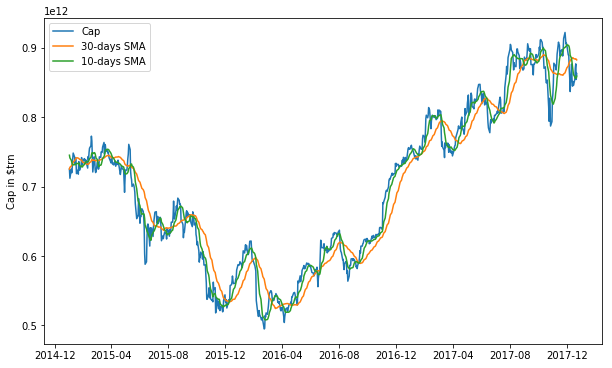

In [7]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $trn')

plt.show()

## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


In [8]:
# Put the rest of you code and analysis for Part I here 
from sklearn.preprocessing import MinMaxScaler

# Converting data to a log space
df_cap_log = np.log(df_cap)
short_rolling_log = df_cap_log.rolling(window=window_1).mean()
long_rolling_log = df_cap_log.rolling(window=window_2).mean()

# Using MinMaxScaler with defined region (epsilon, 1) to make data non-negative and on the same scale
epsilon = 0.1
df_cap_scaler = MinMaxScaler([epsilon, 1]).fit(df_cap_log)

df_cap_norm = pd.DataFrame(data=df_cap_scaler.transform(df_cap_log),
                           columns=df_cap_log.columns,
                           index=df_cap_log.index)

# Rescaling rolling averages using the same scaling factors as the for the market data
long_rolling_norm = pd.DataFrame(data=df_cap_scaler.transform(long_rolling_log.dropna()),
                                 columns=long_rolling_log.columns,
                                 index=long_rolling_log.dropna().index)

short_rolling_norm = pd.DataFrame(data=df_cap_scaler.transform(short_rolling_log.dropna()),
                                  columns=short_rolling_log.columns,
                                  index=short_rolling_log.dropna().index)

display(df_cap_norm.iloc[:5,:10])

# For signals, use the percentage change from one point to another in the long-rolling and short-rolling moving average.
# Again we drop the NaN values (generated because the first value does not have a percentage change)
signal_1 = short_rolling_norm.pct_change(periods=1).shift(-1).dropna().copy()
signal_2 = long_rolling_norm.pct_change(periods=1).shift(-1).dropna().copy()

# Make sure our three datasets all have the same values for same date range.
market = df_cap_norm[df_cap_norm.index.isin(signal_1.index) & df_cap_norm.index.isin(signal_2.index)]
signal_1 = signal_1[signal_1.index.isin(market.index)]
signal_2 = signal_2[signal_2.index.isin(market.index)]

print('Scaled market data:')
display(market.iloc[:5,:10])
print('Scaled signal #1:')
display(signal_1.iloc[:5,:10])
print('Scaled signal #2:')
display(signal_2.iloc[:5,:10])



,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-01-04,0.157602,0.211608,0.100000,0.209723,0.632963,0.350976,0.191274,0.225279,0.442688,0.841472
2010-01-05,0.158535,0.209245,0.117477,0.218882,0.629196,0.360491,0.189602,0.245302,0.447230,0.859443
2010-01-06,0.149876,0.226451,0.133684,0.221219,0.623686,0.360660,0.186035,0.253369,0.442688,0.848439
2010-01-07,0.148877,0.239049,0.155205,0.224325,0.627478,0.355572,0.186246,0.253665,0.487080,0.868311
2010-01-08,0.152455,0.238282,0.149948,0.232930,0.631938,0.357949,0.187296,0.255290,0.505818,0.848733


Scaled market data:


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-02-12,0.131006,0.179518,0.169158,0.190667,0.609049,0.243287,0.162562,0.214124,0.475642,0.744096
2010-02-15,0.128744,0.163969,0.174093,0.195777,0.607544,0.240514,0.171076,0.218299,0.481652,0.743183
2010-02-16,0.129751,0.166713,0.183400,0.199921,0.614873,0.254873,0.174537,0.230911,0.486538,0.733158
2010-02-17,0.126393,0.164243,0.189403,0.208229,0.617649,0.262723,0.179054,0.228696,0.484582,0.736117
2010-02-18,0.123025,0.160666,0.192634,0.205313,0.615568,0.242733,0.176692,0.230734,0.488922,0.739591


Scaled signal #1:


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-02-12,0.015937,0.000599,0.014446,0.038473,0.005668,-0.013326,0.013695,0.009739,-0.007922,0.000289
2010-02-15,0.008590,0.016482,0.023343,0.041404,0.006557,0.003450,0.004697,0.015933,-0.005031,-0.001360
2010-02-16,0.022634,0.030609,0.039398,0.064134,0.006429,0.022694,0.023142,0.022760,0.001923,0.005092
2010-02-17,0.011339,0.020911,0.045313,0.055304,0.002831,0.014868,0.022985,0.024001,0.005816,0.002319
2010-02-18,0.006728,0.022217,0.040011,0.050193,0.002569,0.015938,0.020636,0.022658,0.004558,0.005131


Scaled signal #2:


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-02-12,-0.007328,-0.008750,0.017649,-0.002554,-0.001407,-0.012811,-0.004221,-0.001062,0.002693,-0.004289
2010-02-15,-0.007363,-0.007881,0.015430,-0.003481,-0.000794,-0.012408,-0.003161,-0.002192,0.002709,-0.005535
2010-02-16,-0.006052,-0.011618,0.012844,-0.002393,-0.000335,-0.011650,-0.001470,-0.003766,0.002879,-0.004950
2010-02-17,-0.006703,-0.014811,0.008518,-0.003511,-0.000661,-0.013581,-0.002014,-0.003513,0.000126,-0.005701
2010-02-18,-0.010063,-0.020242,0.007315,-0.008530,-0.001394,-0.016145,-0.003152,-0.004940,-0.002281,-0.004864


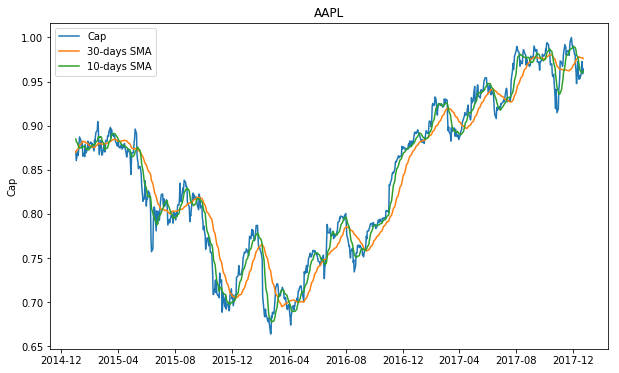

In [9]:
def plot_ticker(ticker, data_dict, start_date = '2015-01-01', end_date = '2017-12-31'):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)

    for i in range(len(data_dict)):
        ax.plot(list(data_dict.values())[i].loc[start_date:end_date, :].index,
                list(data_dict.values())[i].loc[start_date:end_date, ticker],
                label=list(data_dict.keys())[i])

    ax.legend(loc='best')
    ax.set_ylabel('Cap')
    plt.title(ticker)

    plt.show()

data_dict = {'Cap': df_cap_norm, '30-days SMA': long_rolling_norm, '10-days SMA': short_rolling_norm}
plot_ticker('AAPL', data_dict)

In [10]:
## Create a class that holds the model algorithm

import time
from datetime import timedelta

class IRL_model():
    
    def __init__(self, num_timesteps, num_stocks, learning_rate=1e-3):
        
        self.t = num_timesteps
        self.n = num_stocks
        print('Setting up model with t={} time steps and n={} stocks'.format(self.t,self.n))        
        
        print('Setting up tensorflow...', end=' ')        
        # here we set up the graph
        tf.reset_default_graph()
        self.x  = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'x' )  # market
        self.z1 = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'z1' ) # signal 1
        self.z2 = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'z2' ) # sigmal 2

        # weights
        self.w1_init = tf.random_normal([self.n], mean=0.5, stddev=0.1)
        self.w2_init = 1 - self.w1_init
        self.w1      = tf.get_variable('w1', initializer = self.w1_init)
        self.w2      = tf.get_variable('w2', initializer = self.w2_init)
        self.W1      = self.w1*tf.ones(self.n)
        self.W2      = self.w2*tf.ones(self.n)
        
        
        # parameters
        self.sigma = tf.get_variable('sigma', initializer = tf.random_uniform([self.n], minval=0.0, maxval=0.1))
        self.kappa = tf.get_variable('kappa', initializer = tf.random_uniform([self.n], minval=0.0, maxval=1.0))
        self.g     = tf.get_variable('g',     initializer = tf.random_uniform([self.n], minval=0.0, maxval=1.0))
        self.theta = tf.get_variable('theta', initializer = tf.random_uniform([self.n], minval=0.0, maxval=1.0))
        
        self.mu    = tf.zeros([self.n])
        self.Sigma = self.sigma * tf.ones([self.n])
        self.Kappa = self.kappa * tf.ones([self.n])
        self.G     = self.g     * tf.ones([self.n])
        self.Theta = self.theta * tf.ones([self.n])
        
        self.signals1 = tf.multiply(self.W1, self.z1)
        self.signals2 = tf.multiply(self.W2, self.z2)
        self.scale    = tf.slice(self.x, [0,0], [1,-1])
        self.signals  = tf.multiply(self.scale, tf.cumprod(1 + tf.add(self.signals1, self.signals2)))
        
        # add some non-negative constraints on the weights
        self.w1_abs      = self.w1.assign(tf.maximum(0., self.w1))
        self.w2_abs      = self.w2.assign(tf.maximum(0., self.w2))
        # self.g_abs       = self.g.assign(tf.maximum(0., self.g))
        self.constraints = tf.group(self.w1_abs, self.w2_abs)

        # expression

        self.term0 = tf.add(tf.subtract(self.Theta, 0.5*tf.square(self.Sigma)), self.signals)
        self.term1 = tf.multiply(-self.term0, self.x)
        self.term2 = tf.multiply(self.Kappa, tf.exp(self.x))
        self.term3 = tf.multiply(0.5*self.G, tf.exp(2*self.x))
        self.v     = tf.add(tf.add(self.term1, self.term2), self.term3)
        # Do not use last row t = T-1      
        self.V = tf.slice ( self.v, [0,0], [ tf.shape ( self.v ) [0]-1, -1] )
        
        # negative log-likelihood
        self.distribution = tf.contrib.distributions.MultivariateNormalDiag(loc=self.mu, scale_diag=self.Sigma)
        self.log_prob     = self.distribution.log_prob(self.V)
        self.reg_term     = tf.reduce_sum(tf.square(self.w1 + self.w2 - 1))
        self.neg_log_likelihood = -tf.reduce_sum(self.log_prob) + 0.01 * self.reg_term
        
        # configure the optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.train_op  = self.optimizer.minimize(self.neg_log_likelihood)
        
        print ('Model Ready!')
        return
    
    def fit(self, market, signal_1, signal_2, epochs=1000, tol=1e-3):
        start = time.time()
        assert not np.any(np.isnan(market))
        assert not np.any(np.isnan(signal_1))
        assert not np.any(np.isnan(signal_2))
        
        with tf.Session() as sess:
        #with tf.compat.v1.Session() as sess:   # use this line if you are running on a newer version of tf
            sess.run(tf.global_variables_initializer())
            
            # run the first iteration and calculate initial loss
            res = []
            self.loss = []
            res.append(sess.run(self.neg_log_likelihood, \
                                feed_dict = {self.x: market, self.z1: signal_1, self.z2: signal_2}))
            
            # now iterate loss minimization in a loop
            e=1
            while True:
                # solve the optimiser
                sess.run(self.train_op, feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2})
                # abide by contraints
                sess.run(self.constraints) 

                # update loss
                res.append(sess.run(self.neg_log_likelihood, \
                                    feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2}))
                loss_ = np.abs(res[-1] - res[-2])
                self.loss.append(loss_)

                if (e % 200 == 0) or (e == 1):
                    print('Epoch {:5}: Loss: {}'.format(e, loss_))

                if loss_ < tol:
                    print('Converged after {} epochs. Loss: {}'.format(e, loss_))
                    break

                if e >= epochs:
                    print('Specified maximum epochs ({}) reached without convergence. Loss: {}'.format(epochs, loss_))
                    break

                e += 1
                
            end = time.time()            
            
            # Save the coefficients
            self.coefficients = pd.DataFrame([], index = market.columns, \
                                             columns = ['kappa', 'sigma', 'theta', 'g', 'w1', 'w2'] )
            self.coefficients['kappa']   = sess.run(self.kappa)
            self.coefficients['sigma']   = sess.run(self.sigma)
            self.coefficients['theta']   = sess.run(self.theta)
            self.coefficients['g']       = sess.run(self.g)
            self.coefficients['w1']      = sess.run(self.W1)
            self.coefficients['w2']      = sess.run(self.W2)
            
            est_ = sess.run(self.signals, feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2})
            self.estimation = pd.DataFrame(est_, index=market.index, columns=market.columns)
            
        print ('Training Complete. Time Elapsed:', timedelta (seconds=end-start))
               



In [11]:
# Before we run the model, deprecate any warnings from tensorflow

tf.logging.set_verbosity(tf.logging.ERROR)

part1_model = IRL_model(market.shape[0], market.shape[1], learning_rate=1.5e-3)
part1_model.fit(market, signal_1, signal_2, epochs=5000, tol=1)


Setting up model with t=2050 time steps and n=30 stocks
Setting up tensorflow... Model Ready!
Epoch     1: Loss: 5145411072.0
Epoch   200: Loss: 59844.0
Epoch   400: Loss: 32794.0
Epoch   600: Loss: 20442.0
Epoch   800: Loss: 13933.0
Epoch  1000: Loss: 9757.5
Epoch  1200: Loss: 7488.5
Epoch  1400: Loss: 10976.25
Epoch  1600: Loss: 4107.0
Epoch  1800: Loss: 3210.25
Epoch  2000: Loss: 2653.375
Epoch  2200: Loss: 2044.25
Epoch  2400: Loss: 1527.875
Epoch  2600: Loss: 1292.25
Epoch  2800: Loss: 798.0
Epoch  3000: Loss: 1277.28125
Epoch  3200: Loss: 1107.640625
Epoch  3400: Loss: 417.46875
Epoch  3600: Loss: 324.2578125
Epoch  3800: Loss: 313.82421875
Epoch  4000: Loss: 111.046875
Epoch  4200: Loss: 203.76513671875
Epoch  4400: Loss: 380.634765625
Epoch  4600: Loss: 352.685546875
Epoch  4800: Loss: 694.9765625
Converged after 4960 epochs. Loss: 0.67578125
Training Complete. Time Elapsed: 0:06:27.769855


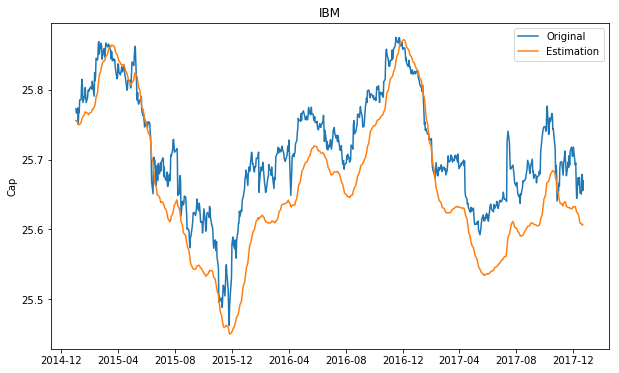

In [15]:
estimation = df_cap_scaler.inverse_transform(part1_model.estimation)
df_est = pd.DataFrame(estimation, columns=part1_model.estimation.columns, 
                      index=part1_model.estimation.index)

data_dict = {'Original': df_cap_log, 'Estimation': df_est}

plot_ticker('IBM', data_dict)



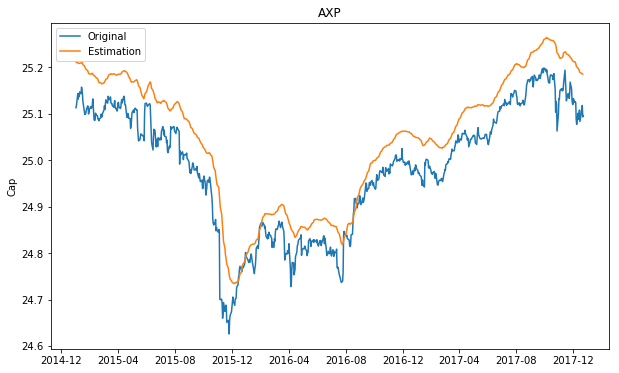

In [17]:
ticker = np.random.choice(df_cap.columns.values)
plot_ticker(ticker, data_dict)

In [18]:
part1_model.coefficients.head()

,kappa,sigma,theta,g,w1,w2
AAPL,-0.031396,0.024016,-0.232574,0.024738,0.117805,0.165020
AXP,-0.188762,0.097240,0.366159,0.558516,0.452756,0.512749
BA,0.195171,0.102746,0.917975,0.344742,0.527499,0.470470
CAT,0.169013,0.150617,0.662201,0.190814,0.277178,0.321331
CSCO,0.003721,0.050671,-0.554661,0.013484,0.000000,0.000000


## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?


In [10]:
import time
from datetime import timedelta

In [11]:
# Put the rest of your code and analysis for Part 2 here.


class IRL_model_with_escape():
    
    def __init__(self, num_timesteps, num_stocks, learning_rate=1e-3):
        
        self.t = num_timesteps
        self.n = num_stocks
        print('Setting up model with t={} time steps and n={} stocks'.format(self.t,self.n))        
        
        print('Setting up tensorflow...', end=' ')        
        # set up the graph
        tf.reset_default_graph()
        self.x  = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'x' )  # market
        self.z1 = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'z1' ) # signal 1
        self.z2 = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'z2' ) # sigmal 2

        # weights
        self.w1_init = tf.random_normal([self.n], mean=0.5, stddev=0.1)
        self.w2_init = 1 - self.w1_init
        self.w1      = tf.get_variable('w1', initializer = self.w1_init)
        self.w2      = tf.get_variable('w2', initializer = self.w2_init)
        self.W1      = self.w1*tf.ones(self.n)
        self.W2      = self.w2*tf.ones(self.n)
        
        # parameters
        self.sigma = tf.get_variable('sigma', initializer = tf.random_uniform([self.n], minval=0.0, maxval=0.1))
        self.kappa = tf.get_variable('kappa', initializer = tf.random_uniform([self.n], minval=0.0, maxval=1.0))
        self.g     = tf.get_variable('g',     initializer = tf.random_uniform([self.n], minval=0.0, maxval=1.0))
        self.theta = tf.get_variable('theta', initializer = tf.random_uniform([self.n], minval=0.0, maxval=1.0))
        
        self.mu    = tf.zeros([self.n])
        self.Sigma = self.sigma * tf.ones([self.n])
        self.Kappa = self.kappa * tf.ones([self.n])
        self.G     = self.g     * tf.ones([self.n])
        self.Theta = self.theta * tf.ones([self.n])
        
        self.signals1 = tf.multiply(self.W1, self.z1)
        self.signals2 = tf.multiply(self.W2, self.z2)
        self.scale    = tf.slice(self.x, [0,0], [1,-1])
        self.signals  = tf.multiply(self.scale, tf.cumprod(1 + tf.add(self.signals1, self.signals2)))
        
        # add some non-negative constraints on the weights
        self.w1_abs      = self.w1.assign(tf.maximum(0., self.w1))
        self.w2_abs      = self.w2.assign(tf.maximum(0., self.w2))
        #self.g_abs       = self.g.assign(tf.maximum(0., self.g))
        self.constraints = tf.group(self.w1_abs, self.w2_abs)
                
        # expression
        self.term0 = tf.add(tf.subtract(self.Theta, 0.5*tf.square(self.Sigma)), self.signals)
        self.term1 = tf.multiply(-self.term0, self.x)
        self.term2 = tf.multiply(self.Kappa, tf.exp(self.x))
        self.term3 = tf.multiply(0.5*self.G, tf.exp(2*self.x))
        self.v     = tf.add(tf.add(self.term1, self.term2), self.term3)
        # Do not use last row t = T-1
        self.V = tf.slice(self.v, [0,0], [tf.shape(self.v)[0]-1, -1])
        
        # for Kramers' escape equation
        # use the hessian to calculate the second order derivative of V wrt x
        self.v_hess = tf.hessians(self.v, self.x)
        self.r = tf.multiply(self.v_hess, tf.exp(tf.multiply(-2 / tf.square(self.sigma), self.V)))
        
        # negative log-likelyhood
        self.distribution = tf.contrib.distributions.MultivariateNormalDiag(loc=self.mu, scale_diag=self.Sigma)
        self.log_prob     = self.distribution.log_prob(self.V)
        self.reg_term     = tf.reduce_sum(tf.square(self.w1 + self.w2 - 1))
        self.neg_log_likelihood = -tf.reduce_sum(self.log_prob) + 0.01 * self.reg_term
        
        # And finally, we configure the optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.train_op  = self.optimizer.minimize(self.neg_log_likelihood)
        
        print('Model Ready!')
        return

    def fit(self, market, signal_1, signal_2, epochs=1000, tol=1e-3):
        start = time.time()
        assert not np.any(np.isnan(market))
        assert not np.any(np.isnan(signal_1))
        assert not np.any(np.isnan(signal_2))
        
        with tf.Session() as sess:
        # with tf.compat.v1.Session() as sess:            # use this line if you are running on a newer version of tf
            sess.run(tf.global_variables_initializer())
            
            # run the first iteration and calculate initial loss
            res = []
            self.loss = []
            res.append(sess.run(self.neg_log_likelihood, \
                                feed_dict = {self.x: market, self.z1: signal_1, self.z2: signal_2}))
            
            # now iterate loss minimization in a loop
            e=1
            while True:
                # solve the optimiser
                sess.run(self.train_op, feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2})
                # abide by contraints
                sess.run(self.constraints) 

                # update loss
                res.append(sess.run(self.neg_log_likelihood, \
                                    feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2}))
                loss_ = np.abs(res[-1] - res[-2])
                self.loss.append(loss_)

                if (e % 200 == 0) or (e == 1):
                    print('Epoch {:5}: Loss: {}'.format(e, loss_))

                if loss_ < tol:
                    print('Converged after {} epochs. Loss: {}'.format(e, loss_))
                    break

                if e >= epochs:
                    print('Specified maximum epochs ({}) reached without convergence. Loss: {}'.format(epochs, loss_))
                    break

                e += 1
                
            end = time.time()           

            
            # Save the coefficients
            self.coefficients = pd.DataFrame([], index = market.columns, \
                                             columns = ['kappa', 'sigma', 'theta', 'g', 'w1', 'w2'] )
            self.coefficients['kappa']   = sess.run(self.kappa)
            self.coefficients['sigma']   = sess.run(self.sigma)
            self.coefficients['theta']   = sess.run(self.theta)
            self.coefficients['g']       = sess.run(self.g)
            self.coefficients['w1']      = sess.run(self.W1)
            self.coefficients['w2']      = sess.run(self.W2)
            
            est_ = sess.run(self.signals, feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2})
            self.estimation = pd.DataFrame(est_, index=market.index, columns=market.columns)
            
            # r_ = sess.run(self.r, feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2})
            # self.rate = pd.DataFrame(r_, index=market.index, columns=market.columns)
            
        print('Training Complete. Time Elapsed:', timedelta(seconds=end-start))
        

In [12]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [13]:
part2_model = IRL_model_with_escape(market.shape[0], market.shape[1], learning_rate=1.5e-3)
part2_model.fit(market, signal_1, signal_2, epochs=5000, tol=1)

Setting up model with t=2050 time steps and n=30 stocks
Setting up tensorflow... Model Ready!
Epoch     1: Loss: 335906944.0
Epoch   200: Loss: 44693.0
Epoch   400: Loss: 14903.5
Epoch   600: Loss: 6820.75
Epoch   800: Loss: 3582.875
Epoch  1000: Loss: 1951.625
Epoch  1200: Loss: 888.625
Epoch  1400: Loss: 1495.15625
Epoch  1600: Loss: 478.0625
Epoch  1800: Loss: 298.78125
Epoch  2000: Loss: 1185.453125
Epoch  2200: Loss: 241.09375
Epoch  2400: Loss: 290.109375
Epoch  2600: Loss: 310.15625
Converged after 2702 epochs. Loss: 0.609375
Training Complete. Time Elapsed: 0:03:32.465446


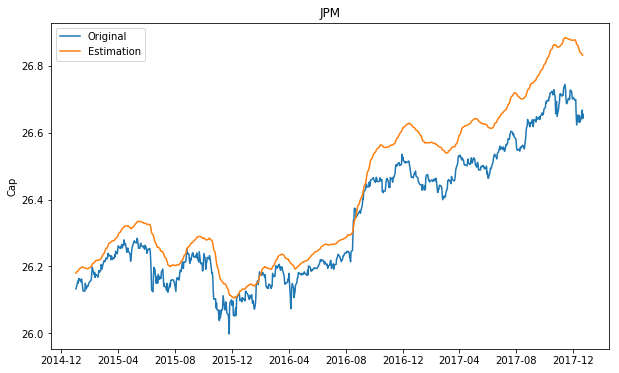

In [19]:
estimation_2 = df_cap_scaler.inverse_transform(part2_model.estimation)
df_est = pd.DataFrame(estimation_2, columns=part2_model.estimation.columns, index=part2_model.estimation.index)

data_dict = {'Original': df_cap_log, 'Estimation': df_est}

plot_ticker('JPM', data_dict)



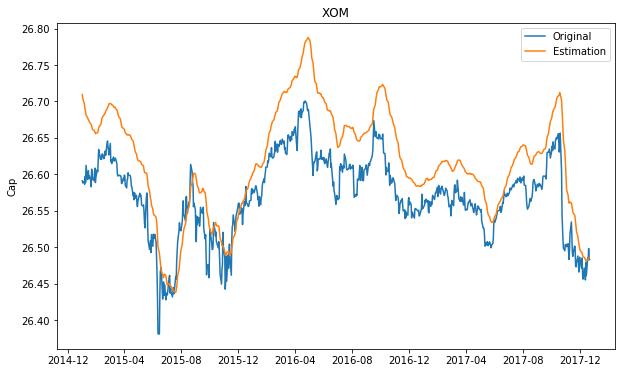

In [20]:
ticker = np.random.choice(df_cap.columns.values)
plot_ticker(ticker, data_dict)

In [21]:
part2_model.coefficients.head()


,kappa,sigma,theta,g,w1,w2
AAPL,0.566805,0.105659,0.790001,0.134911,0.515898,0.698317
AXP,0.405477,0.188296,1.223299,0.153644,0.337780,0.281521
BA,-0.160609,0.079996,0.936646,0.690926,0.401185,0.470483
CAT,0.368615,0.038711,0.342930,0.377554,0.986470,0.569838
CSCO,0.235380,0.109080,1.098173,0.331266,0.000000,0.000000


In [24]:
part2_model.r

<tf.Tensor 'Mul_16:0' shape=(1, ?, 30, ?, 30) dtype=float32>

In IRL Model with Escape, convergence occurs sooner than in IRL Model alone. 


## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


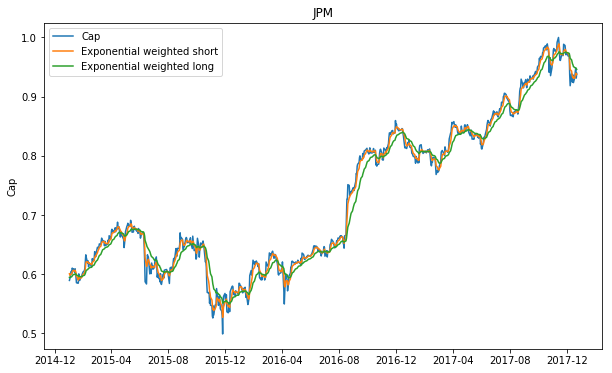

In [11]:
# Put the rest of your code and analysis for Part 3 here.
exponential_weighted_short = df_cap_norm.ewm(span=5, adjust=False).mean()
exponential_weighted_long  = df_cap_norm.ewm(span=20, adjust=False).mean()

data_dict = {'Cap': df_cap_norm, 
             'Exponential weighted short': exponential_weighted_short, 
             'Exponential weighted long': exponential_weighted_long}
plot_ticker('JPM', data_dict)

In [12]:
# For the signals, use the percentage change from one point to another in the moving average.
# Drop the NaN values (generated because the first value does not have a percentage change)
signal_2_1 = exponential_weighted_short.pct_change(periods=1).shift(-1).dropna().copy()
signal_2_2 = exponential_weighted_long.pct_change(periods=1).shift(-1).dropna().copy()

# Ensure the three datasets all have the same values for same date range.
market_2 = df_cap_norm[df_cap_norm.index.isin(signal_2_1.index) & df_cap_norm.index.isin(signal_2_2.index)]
signal_2_1 = signal_2_1[signal_2_1.index.isin(market_2.index)]
signal_2_2 = signal_2_2[signal_2_2.index.isin(market_2.index)]

print('Scaled market data:')
display(market_2.iloc[:5,:10])
print('Scaled signal #1:')
display(signal_2_1.iloc[:5,:10])
print('Scaled signal #2:')
display(signal_2_2.iloc[:5,:10])

Scaled market data:


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-01-04,0.157602,0.211608,0.100000,0.209723,0.632963,0.350976,0.191274,0.225279,0.442688,0.841472
2010-01-05,0.158535,0.209245,0.117477,0.218882,0.629196,0.360491,0.189602,0.245302,0.447230,0.859443
2010-01-06,0.149876,0.226451,0.133684,0.221219,0.623686,0.360660,0.186035,0.253369,0.442688,0.848439
2010-01-07,0.148877,0.239049,0.155205,0.224325,0.627478,0.355572,0.186246,0.253665,0.487080,0.868311
2010-01-08,0.152455,0.238282,0.149948,0.232930,0.631938,0.357949,0.187296,0.255290,0.505818,0.848733


Scaled signal #1:


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-01-04,0.001973,-0.003722,0.058258,0.014557,-0.001984,0.009037,-0.002914,0.029627,0.003420,0.007119
2010-01-05,-0.016964,0.024714,0.087748,0.013228,-0.004233,0.006130,-0.008182,0.030777,-0.001136,0.000384
2010-01-06,-0.013650,0.035517,0.116100,0.013505,-0.000824,-0.000698,-0.005129,0.020318,0.032591,0.008069
2010-01-07,-0.001436,0.021723,0.055710,0.022011,0.001815,0.001759,-0.001576,0.015496,0.034675,-0.002299
2010-01-08,-0.011390,-0.003834,0.019291,0.084432,-0.000062,0.023326,-0.020583,0.002385,0.028273,-0.007911


Scaled signal #2:


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS
date,,,,,,,,,,
2010-01-04,0.000564,-0.001063,0.016645,0.004159,-0.000567,0.002582,-0.000832,0.008465,0.000977,0.002034
2010-01-05,-0.004720,0.006789,0.029995,0.004805,-0.001343,0.002376,-0.002531,0.010976,-0.000093,0.000594
2010-01-06,-0.004897,0.011739,0.045922,0.005724,-0.000645,0.000771,-0.002191,0.009946,0.009458,0.002780
2010-01-07,-0.002270,0.010158,0.035153,0.009000,0.000089,0.001338,-0.001461,0.009577,0.012467,0.000304
2010-01-08,-0.004983,0.003691,0.025294,0.028891,-0.000281,0.007597,-0.006843,0.006229,0.012914,-0.001560


In [22]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [23]:
part3_model = IRL_model(market_2.shape[0], market_2.shape[1], learning_rate=1.5e-3)
part3_model.fit(market_2, signal_2_1, signal_2_2, epochs=5000, tol=1)

Setting up model with t=2079 time steps and n=30 stocks
Setting up tensorflow... Model Ready!
Epoch     1: Loss: 7818556.0
Epoch   200: Loss: 6032.0625
Epoch   400: Loss: 1476.5
Epoch   600: Loss: 523.75
Epoch   800: Loss: 211.3583984375
Epoch  1000: Loss: 109.2890625
Epoch  1200: Loss: 63.0625
Epoch  1400: Loss: 45.18359375
Epoch  1600: Loss: 284.4765625
Epoch  1800: Loss: 327.3359375
Converged after 1822 epochs. Loss: 0.3125
Training Complete. Time Elapsed: 0:02:51.903191


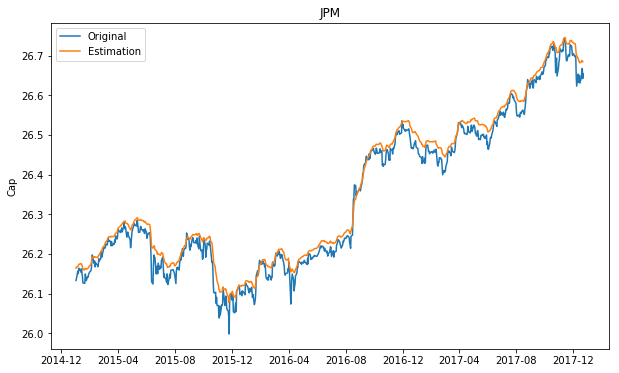

In [25]:
estimation_3 = df_cap_scaler.inverse_transform(part3_model.estimation)
df_est = pd.DataFrame(estimation_3, columns=part3_model.estimation.columns, index=part3_model.estimation.index)

data_dict = {'Original': df_cap_log, 'Estimation': df_est}

plot_ticker('JPM', data_dict)


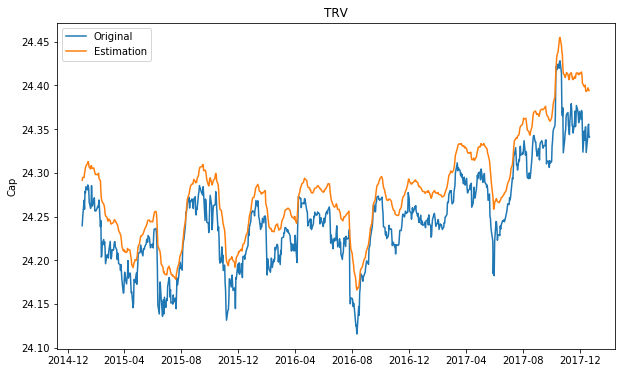

In [21]:

ticker = np.random.choice(df_cap.columns.values)
plot_ticker(ticker, data_dict)

## Part 4 (Optional): Show me something else (Max 10 points).

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [ ]:
# Put the rest of your code and analysis for Part 3 here.